In [1]:
from collections import Counter

import pandas as pd
import seaborn as sns

from src.coding.labels import LABELS
from src.db import load
from src.db.connect import make_engine

In [2]:
# setup
engine = make_engine("DB")

pd.set_option("display.max_colwidth", 512)
pd.set_option("display.max_rows", 512)

palette = {label: LABELS[label]["color"] for label in LABELS}

In [3]:
df = load.label_data(engine, batch=1)

In [4]:
df.shape

(12420, 3)

# Progress


## number of examples by coder


In [5]:
df.groupby("username").sample_id.count().reset_index().sort_values("sample_id", ascending=False)

,username,sample_id
0,coudry,2500
2,grabsch,2500
4,richter,2500
5,riedel,2500
6,schadt,2312
3,remer,100
1,erhard,8


## number of examples labelled x number of coders


In [6]:
counts = (
    df.groupby("sample_id")
    .username.count()
    .reset_index()
    .groupby("username")
    .count()
    .reset_index()
    .sort_values("username", ascending=False)
)
counts["cumsum"] = counts.sample_id.cumsum()
counts.columns = ["n_coders", "n_samples", "cumsum"]
counts.sort_values("n_coders", ascending=False)

,n_coders,n_samples,cumsum
6,7,2,2
5,6,91,93
4,5,1369,1462
3,4,937,2399
2,3,361,2760
1,2,87,2847
0,1,10,2857


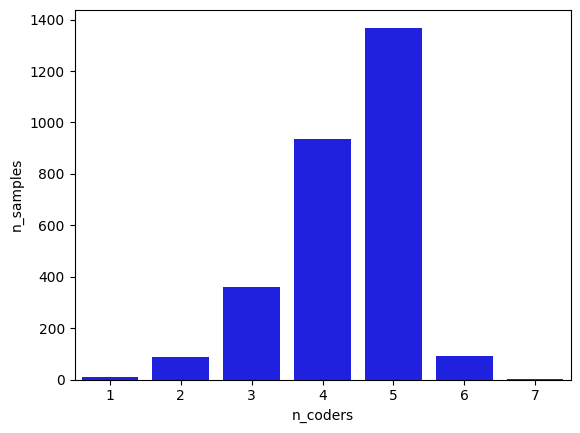

In [7]:
_ = sns.barplot(counts, x="n_coders", y="n_samples", color="blue")

# Code frequencies


## raw number of codes


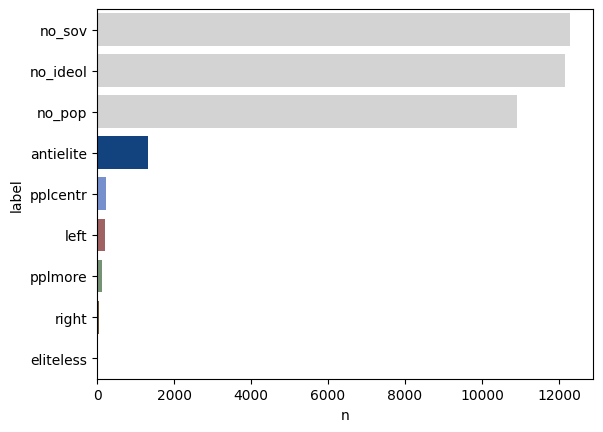

In [8]:
counts = Counter(label for labels in df.labels for label in labels)
plot_df = pd.DataFrame(counts.items(), columns=["label", "n"])

_ = sns.barplot(plot_df.sort_values("n", ascending=False), x="n", y="label", palette=palette)

## raw number of codes (log-scaled)


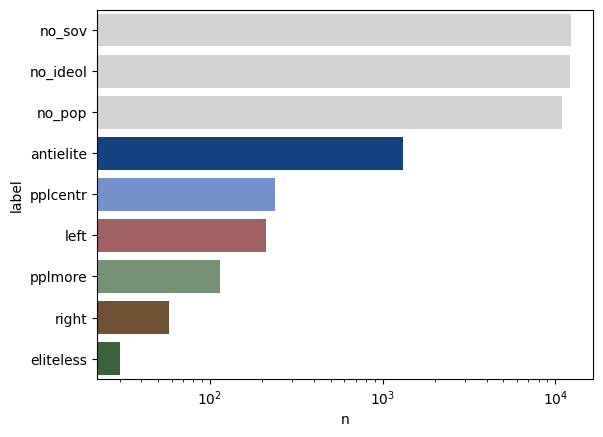

In [9]:
grid = sns.barplot(plot_df.sort_values("n", ascending=False), x="n", y="label", palette=palette)
grid.set_xscale("log")

# Code congruency

- congruency means the ratio of coders, that gave any code


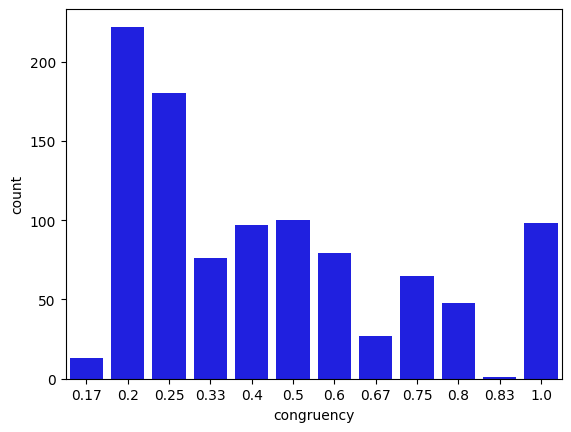

In [16]:
rows = []
for sample_id, group in df.groupby("sample_id"):
    n_coders = len(set(group.username))
    if n_coders == 1:
        continue
    label_counts = Counter(
        label for labels in group.labels for label in labels if not label.startswith("no_")
    )
    ratio = {label: count / n_coders for label, count in label_counts.items()}

    for label, value in ratio.items():
        rows.append((sample_id, label, round(value, 2)))


counts = pd.DataFrame(rows, columns=["sample_id", "label", "congruency"])

_ = sns.countplot(counts, x="congruency", color="blue")

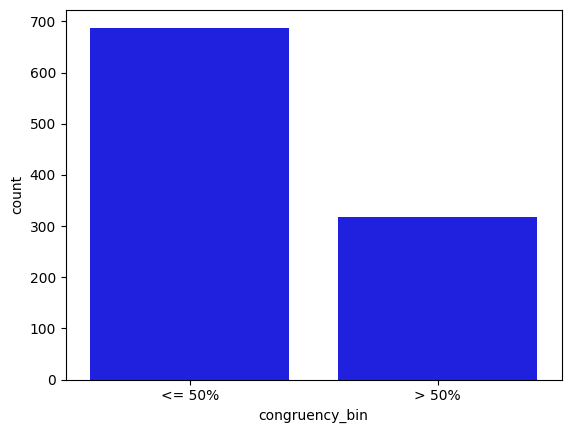

In [12]:
counts["congruency_bin"] = counts.congruency.apply(lambda x: "<= 50%" if x <= 0.5 else "> 50%")

_ = sns.countplot(counts, x="congruency_bin", color="blue", order=["<= 50%", "> 50%"])